In [2]:
from scipy.io import loadmat, savemat
from math import pi
import pickle

import matplotlib.pyplot as plt
import torch
import torchaudio

%load_ext autoreload
%autoreload 2
%matplotlib inline

from dstft import DSTFT, FDSTFT, entropy_loss, fast_sst, frequency_tracking

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(1802);

In [3]:
# specs = {} 
# stfts = {}
# wins = {}
# losses = {} 
# f_hats = {} 
# ss = {} 
# losses2 = {} 
# f_hats2 = {} 

# with open("../fig/3_specs.pkl", "wb") as file: pickle.dump(specs, file, pickle.HIGHEST_PROTOCOL)
# with open("../fig/3_stfts.pkl", "wb") as file: pickle.dump(stfts, file, pickle.HIGHEST_PROTOCOL)
# with open("../fig/3_wins.pkl", "wb") as file: pickle.dump(wins, file, pickle.HIGHEST_PROTOCOL)
# with open("../fig/3_losses.pkl", "wb") as file: pickle.dump(losses, file, pickle.HIGHEST_PROTOCOL)
# with open("../fig/3_f_hats.pkl", "wb") as file: pickle.dump(f_hats, file, pickle.HIGHEST_PROTOCOL)
# with open("../fig/3_ss.pkl", "wb") as file: pickle.dump(ss, file, pickle.HIGHEST_PROTOCOL)
# with open("../fig/3_losses2.pkl", "wb") as file: pickle.dump(losses2, file, pickle.HIGHEST_PROTOCOL)
# with open("../fig/3_f_hats2.pkl", "wb") as file: pickle.dump(f_hats2, file, pickle.HIGHEST_PROTOCOL)

torch.Size([40000])


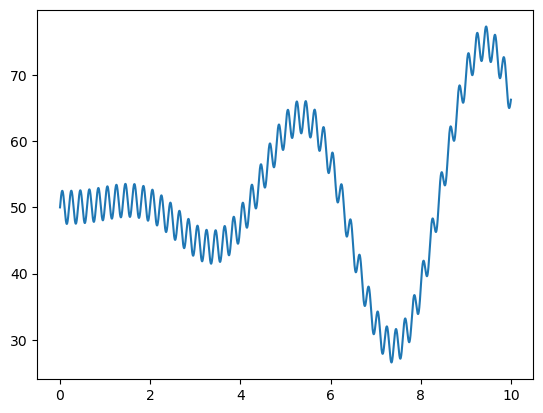

In [4]:
specs = {}
sr = 4_000

def freq(t): 
    f = 25 * torch.sin(1.5*t) * torch.hann_window(2*t.shape[0])[:t.shape[0]] + 50 + 2.5 * torch.sin(10*pi*t)
    return f

t = torch.arange(0, 20, 1/sr)[:int(20*sr/2)]
f = freq(t)
#f = f[:40_000]
#t = t[:40_000]
phase = torch.cumsum(f, dim=0) 
x = torch.sin( 1.5*2*pi*phase/sr + 2*pi*torch.rand(t.shape)/sr)
x += torch.sin( 6*2*pi*phase/sr + pi*2*torch.rand(t.shape)/sr)
x += torch.sin( 12*2*pi*phase/sr + 2*pi*2*torch.rand(t.shape)/sr)
x += torch.sin( 24*2*pi*phase/sr + 4*pi*2*torch.rand(t.shape)/sr)
x += 0.05 * torch.randn(x.shape)
x = x[None, ...].to(device)
plt.plot(t, f)
print(f.shape)
support = 750; stride = 100


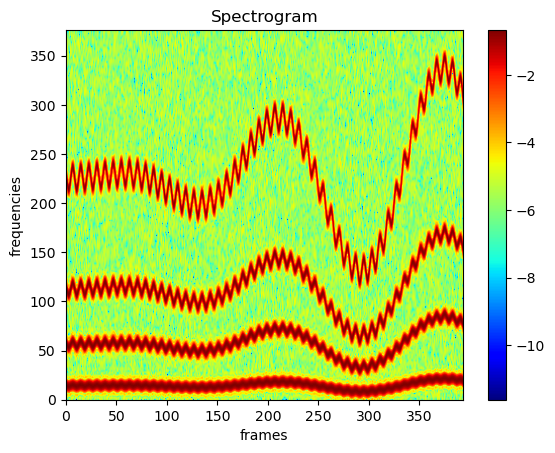

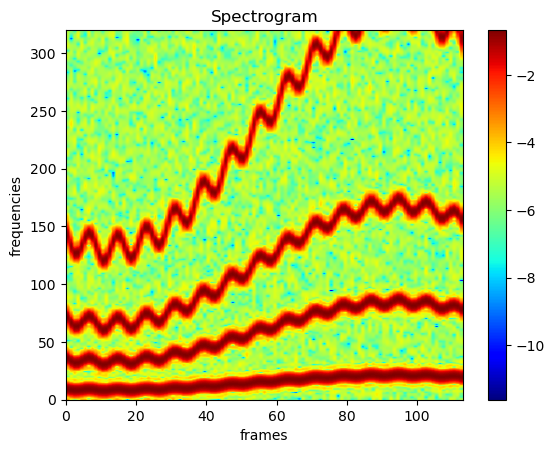

In [5]:
dstft = FDSTFT(x, win_length=200,  support=support, stride=stride, win_requires_grad=False, stride_requires_grad=False, win_p=None, stride_p=None)
spec, stft, real, imag, phase = dstft(x)
dstft.print(spec, weights=False, wins=False, bar=True)
dstft.print(spec[:, :320, 280:410], x, bar=True, wins=False, weights=False) 

with open("../fig/3_specs.pkl", "rb") as file: specs = pickle.load(file)
specs['200'] = spec.detach().cpu()
with open("../fig/3_specs.pkl", "wb") as file: pickle.dump(specs, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/3_stfts.pkl", "rb") as file: stfts = pickle.load(file)
stfts['200'] = stft.detach().cpu()
with open("../fig/3_stfts.pkl", "wb") as file: pickle.dump(stfts, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/3_wins.pkl", "rb") as file: wins = pickle.load(file)
wins['200'] = dstft.actual_win_length.mean().detach().cpu()
with open("../fig/3_wins.pkl", "wb") as file: pickle.dump(wins, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/3_losses.pkl", "rb") as file: losses = pickle.load(file)
losses['200'] = entropy_loss(spec).cpu()
with open("../fig/3_losses.pkl", "wb") as file: pickle.dump(losses, file, pickle.HIGHEST_PROTOCOL)

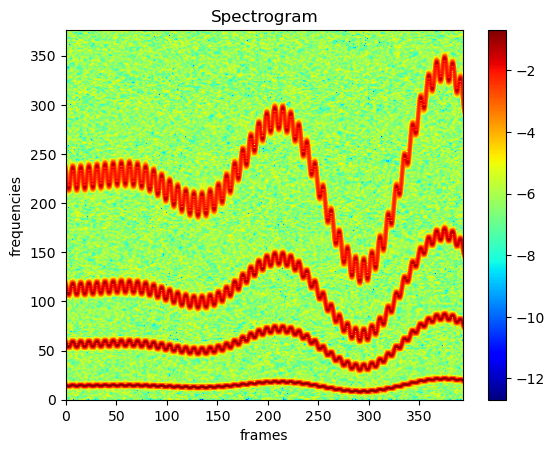

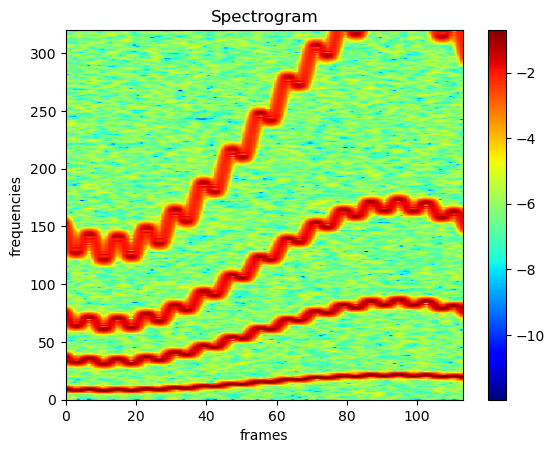

In [6]:
dstft = FDSTFT(x, win_length=650,  support=support, stride=stride, win_requires_grad=False, stride_requires_grad=False, win_p=None, stride_p=None)
spec, stft, real, imag, phase = dstft(x)
dstft.print(spec, weights=False, wins=False, bar=True)
dstft.print(spec[:, :320, 280:410], x, bar=True, wins=False, weights=False) 

with open("../fig/3_specs.pkl", "rb") as file: specs = pickle.load(file)
specs['650'] = spec.detach().cpu()
with open("../fig/3_specs.pkl", "wb") as file: pickle.dump(specs, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/3_stfts.pkl", "rb") as file: stfts = pickle.load(file)
stfts['650'] = stft.detach().cpu()
with open("../fig/3_stfts.pkl", "wb") as file: pickle.dump(stfts, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/3_wins.pkl", "rb") as file: wins = pickle.load(file)
wins['650'] = dstft.actual_win_length.mean().detach().cpu()
with open("../fig/3_wins.pkl", "wb") as file: pickle.dump(wins, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/3_losses.pkl", "rb") as file: losses = pickle.load(file)
losses['650'] = entropy_loss(spec).cpu()
with open("../fig/3_losses.pkl", "wb") as file: pickle.dump(losses, file, pickle.HIGHEST_PROTOCOL)

Single window length

Epoch 00103: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00203: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00303: reducing learning rate of group 0 to 1.0000e-01.
302 390.0


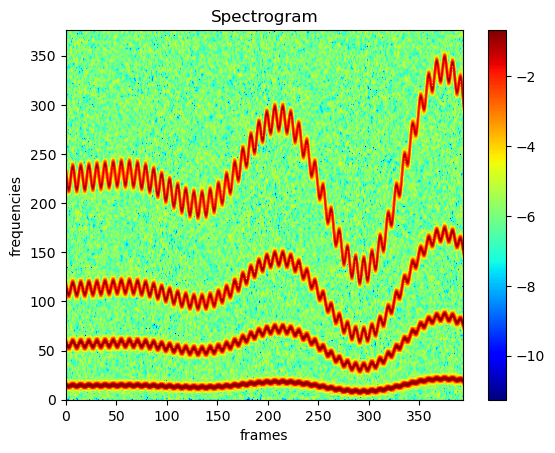

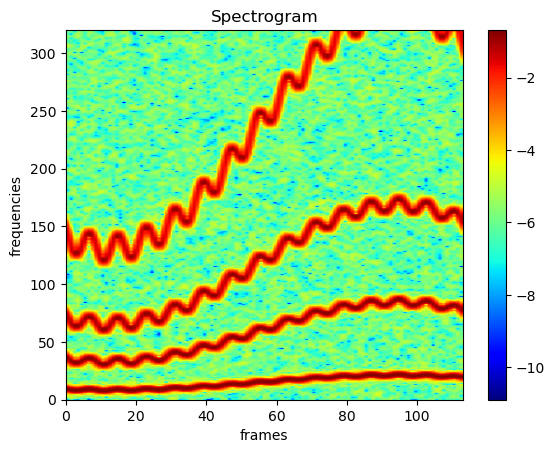

In [6]:
dstft = FDSTFT(x, win_length=577,   support=support, stride=stride, win_requires_grad=True, stride_requires_grad=False, win_p=None, stride_p=None)
params = [{'params': dstft.win_length,    'lr': 100.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=99, verbose=True)

min_err = 100
min_win = 0

for epoch in range(1_000):
    opt.zero_grad()    
    spec, stft, *_ = dstft(x)
    err = entropy_loss(spec)
    err.backward()    
    opt.step()
    sch.step(err)
    
    if err < min_err:
        min_err = err
        min_win = dstft.win_length.item()
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch, f'{dstft.win_length.item():.1f}')
dstft.print(spec, x, bar=True, wins=False, weights=False)
dstft.print(spec[:, :320, 280:410], x, bar=True, wins=False, weights=False)

with open("../fig/3_specs.pkl", "rb") as file: specs = pickle.load(file)
specs['single'] = spec.detach().cpu()
with open("../fig/3_specs.pkl", "wb") as file: pickle.dump(specs, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/3_stfts.pkl", "rb") as file: stfts = pickle.load(file)
stfts['single'] = stft.detach().cpu()
with open("../fig/3_stfts.pkl", "wb") as file: pickle.dump(stfts, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/3_wins.pkl", "rb") as file: wins = pickle.load(file)
wins['single'] = dstft.actual_win_length.mean().detach().cpu()
with open("../fig/3_wins.pkl", "wb") as file: pickle.dump(wins, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/3_losses.pkl", "rb") as file: losses = pickle.load(file)
losses['single'] = entropy_loss(spec).detach().cpu()
with open("../fig/3_losses.pkl", "wb") as file: pickle.dump(losses, file, pickle.HIGHEST_PROTOCOL)

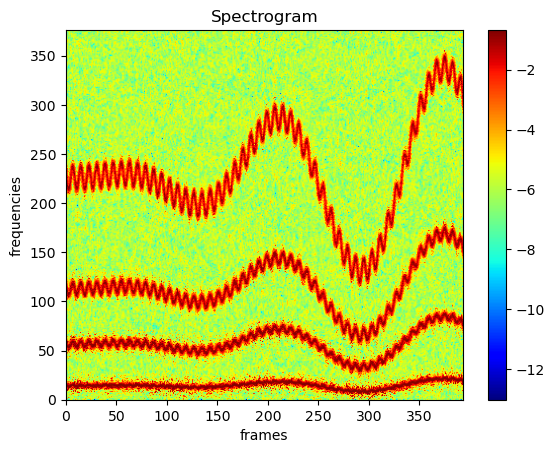

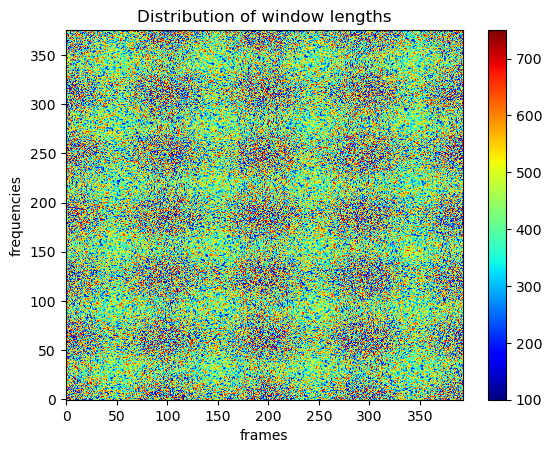

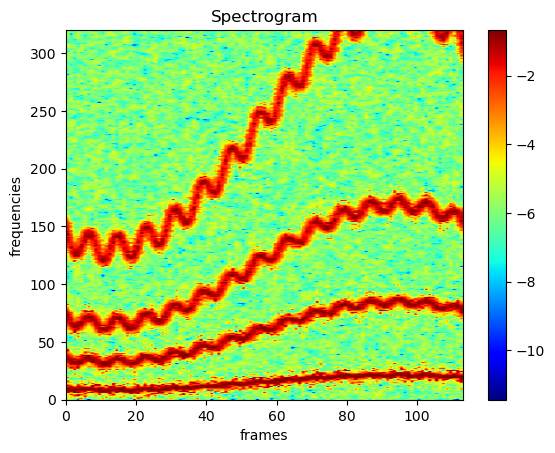

In [7]:
dstft = DSTFT(x, win_length=577,  support=support, stride=stride, win_requires_grad=True, stride_requires_grad=False, win_p='tf', win_min=100)
dstft.win_length.data = dstft.win_min + (dstft.win_max - dstft.win_min) * torch.rand(dstft.win_length.size(), device=device)
spec, stft, *_ = dstft(x)
dstft.print(spec, wins=False, bar=True)
dstft.print(spec[:, :320, 280:410], x, bar=True, wins=False, weights=False)


with open("../fig/3_specs.pkl", "rb") as file: specs = pickle.load(file)
specs['random'] = spec.detach().cpu()
with open("../fig/3_specs.pkl", "wb") as file: pickle.dump(specs, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/3_stfts.pkl", "rb") as file: stfts = pickle.load(file)
stfts['random'] = stft.detach().cpu()
with open("../fig/3_stfts.pkl", "wb") as file: pickle.dump(stfts, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/3_wins.pkl", "rb") as file: wins = pickle.load(file)
wins['random'] = dstft.actual_win_length.mean().detach().cpu()
with open("../fig/3_wins.pkl", "wb") as file: pickle.dump(wins, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/3_losses.pkl", "rb") as file: losses = pickle.load(file)
losses['random'] = entropy_loss(spec).detach().cpu()
with open("../fig/3_losses.pkl", "wb") as file: pickle.dump(losses, file, pickle.HIGHEST_PROTOCOL)

Time-varying window length

Epoch 00135: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00249: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00349: reducing learning rate of group 0 to 1.0000e-01.
348


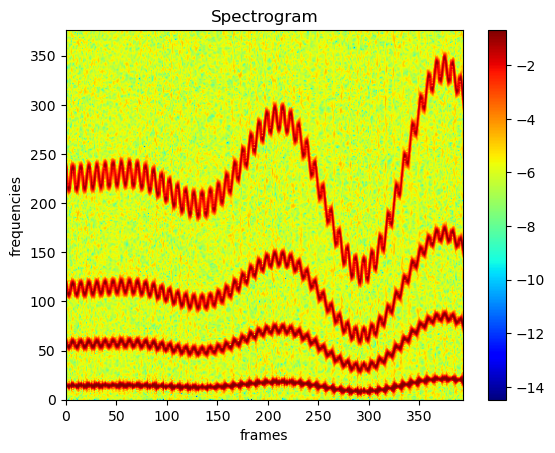

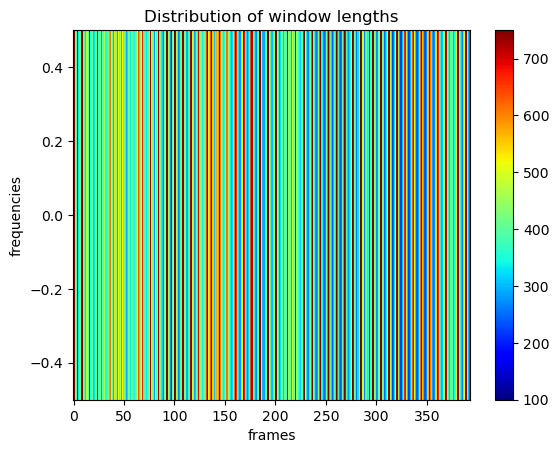

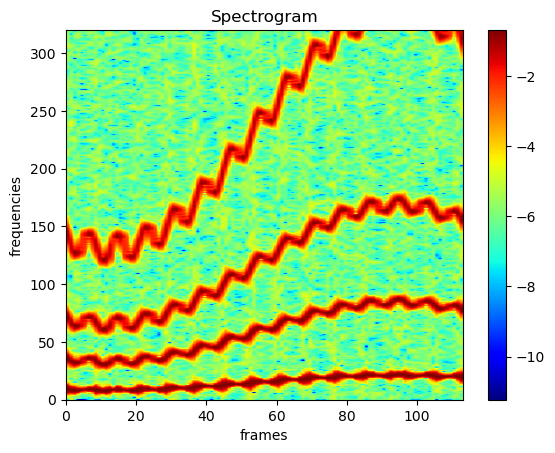

In [8]:
dstft = FDSTFT(x, win_length=577,   support=support, stride=stride, win_requires_grad=True, stride_requires_grad=False, win_p='t', win_min=100)
params = [{'params': dstft.win_length, 'lr': 100.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=99, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()    
    spec, stft, *_ = dstft(x)
    err = entropy_loss(spec)
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
dstft.print(spec, x, bar=True, wins=False)
dstft.print(spec[:, :320, 280:410], x, bar=True, wins=False, weights=False)

with open("../fig/3_specs.pkl", "rb") as file: specs = pickle.load(file)
specs['t'] = spec.detach().cpu()
with open("../fig/3_specs.pkl", "wb") as file: pickle.dump(specs, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/3_stfts.pkl", "rb") as file: stfts = pickle.load(file)
stfts['t'] = stft.detach().cpu()
with open("../fig/3_stfts.pkl", "wb") as file: pickle.dump(stfts, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/3_wins.pkl", "rb") as file: wins = pickle.load(file)
wins['t'] = dstft.actual_win_length.mean().detach().cpu()
with open("../fig/3_wins.pkl", "wb") as file: pickle.dump(wins, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/3_losses.pkl", "rb") as file: losses = pickle.load(file)
losses['t'] = entropy_loss(spec).detach().cpu()
with open("../fig/3_losses.pkl", "wb") as file: pickle.dump(losses, file, pickle.HIGHEST_PROTOCOL)

Epoch 00170: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00307: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00407: reducing learning rate of group 0 to 1.0000e-01.
406


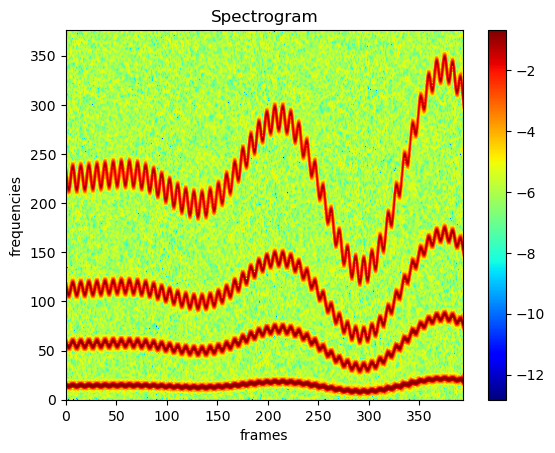

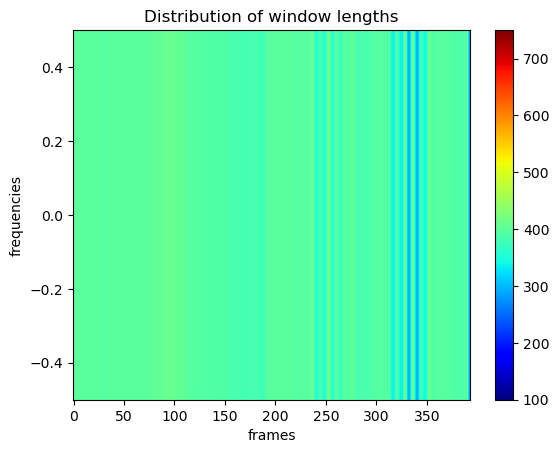

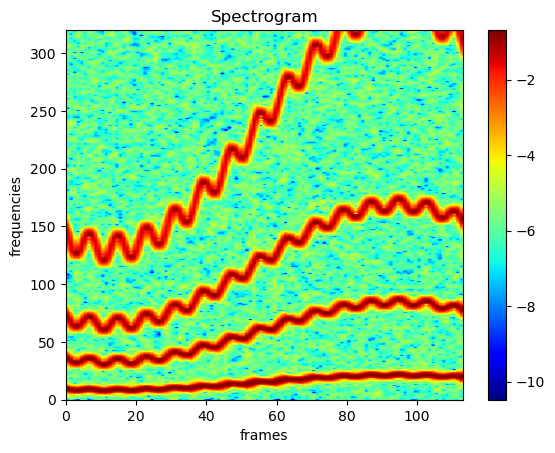

In [9]:
dstft = FDSTFT(x, win_length=577,   support=support, stride=stride, win_requires_grad=True, stride_requires_grad=False, win_p='t', win_min=100)
params = [{'params': dstft.win_length, 'lr': 100.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=99, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()    
    spec, stft, *_ = dstft(x)
    err = entropy_loss(spec) + 0.0005 * (dstft.actual_win_length.diff(dim=1).pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break

print(epoch)
dstft.print(spec, x, bar=True, wins=False)
dstft.print(spec[:, :320, 280:410], x, bar=True, wins=False, weights=False)

with open("../fig/3_specs.pkl", "rb") as file: specs = pickle.load(file)
specs['t2'] = spec.detach().cpu()
with open("../fig/3_specs.pkl", "wb") as file: pickle.dump(specs, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/3_stfts.pkl", "rb") as file: stfts = pickle.load(file)
stfts['t2'] = stft.detach().cpu()
with open("../fig/3_stfts.pkl", "wb") as file: pickle.dump(stfts, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/3_wins.pkl", "rb") as file: wins = pickle.load(file)
wins['t2'] = dstft.actual_win_length.mean().detach().cpu()
with open("../fig/3_wins.pkl", "wb") as file: pickle.dump(wins, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/3_losses.pkl", "rb") as file: losses = pickle.load(file)
losses['t2'] = entropy_loss(spec).detach().cpu()
with open("../fig/3_losses.pkl", "wb") as file: pickle.dump(losses, file, pickle.HIGHEST_PROTOCOL)

torch.cuda.empty_cache()

Frequency-varying window length

Epoch 00144: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00244: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00344: reducing learning rate of group 0 to 1.0000e-01.
343


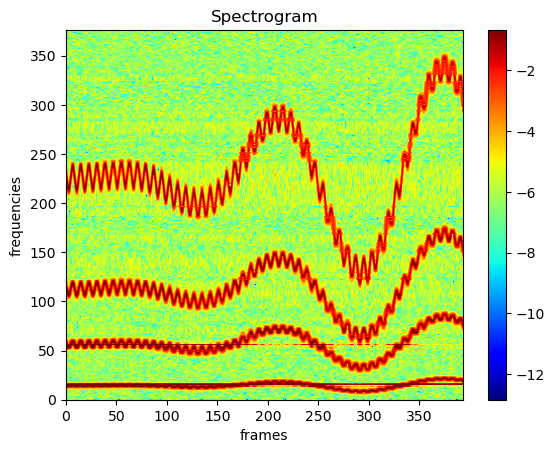

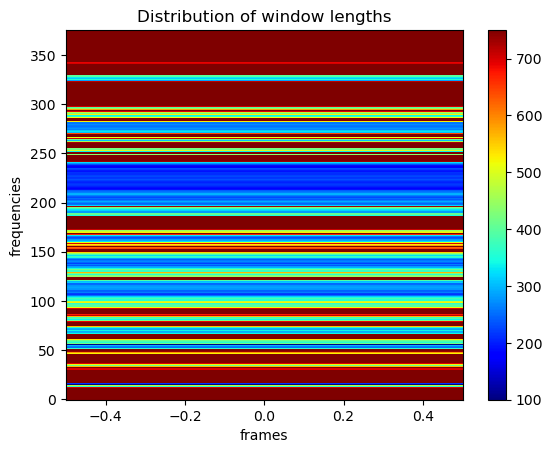

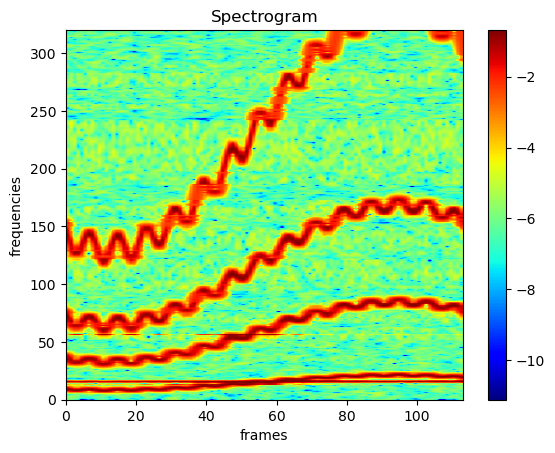

In [10]:
dstft = DSTFT(x, win_length=577,   support=support, stride=stride, win_requires_grad=True, stride_requires_grad=False, win_p='f', win_min=100)
params = [{'params': dstft.win_length,    'lr': 100.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=99, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()
    spec, stft, *_ = dstft(x)
    err = entropy_loss(spec)
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
dstft.print(spec, x, wins=False, bar=True)
dstft.print(spec[:, :320, 280:410], x, bar=True, wins=False, weights=False)

with open("../fig/3_specs.pkl", "rb") as file: specs = pickle.load(file)
specs['f'] = spec.detach().cpu()
with open("../fig/3_specs.pkl", "wb") as file: pickle.dump(specs, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/3_stfts.pkl", "rb") as file: stfts = pickle.load(file)
stfts['f'] = stft.detach().cpu()
with open("../fig/3_stfts.pkl", "wb") as file: pickle.dump(stfts, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/3_wins.pkl", "rb") as file: wins = pickle.load(file)
wins['f'] = dstft.actual_win_length.mean().detach().cpu()
with open("../fig/3_wins.pkl", "wb") as file: pickle.dump(wins, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/3_losses.pkl", "rb") as file: losses = pickle.load(file)
losses['f'] = entropy_loss(spec).detach().cpu()
with open("../fig/3_losses.pkl", "wb") as file: pickle.dump(losses, file, pickle.HIGHEST_PROTOCOL)

torch.cuda.empty_cache()

Epoch 00101: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00201: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00301: reducing learning rate of group 0 to 1.0000e-01.
300


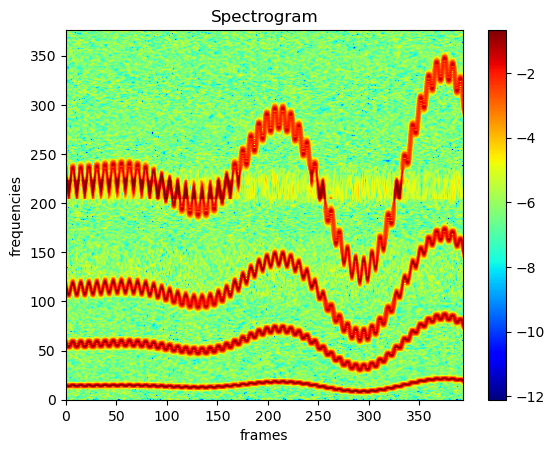

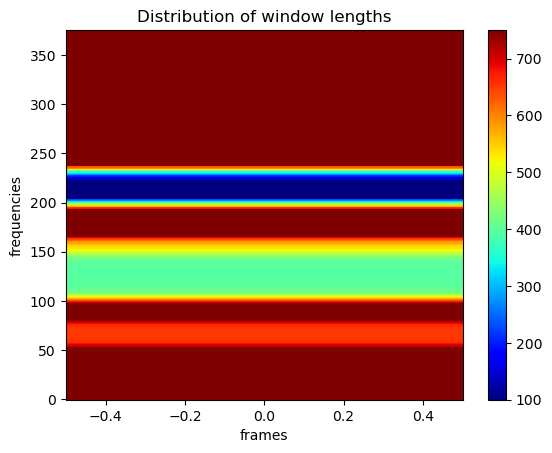

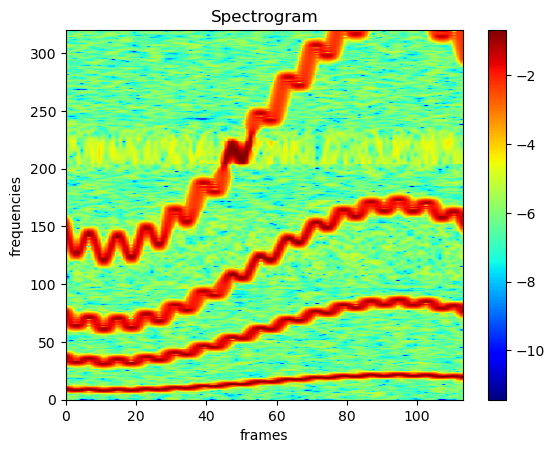

In [4]:
dstft = DSTFT(x, win_length=577,   support=support, stride=stride, win_requires_grad=True, stride_requires_grad=False, win_p='f', win_min=100)
params = [{'params': dstft.win_length, 'lr': 100.0},  ]
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=99, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()
    spec, stft, *_ = dstft(x)
    err = entropy_loss(spec) + 0.1 * (dstft.actual_win_length.diff(dim=0).pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
dstft.print(spec, x, wins=False, bar=True)
dstft.print(spec[:, :320, 280:410], x, bar=True, wins=False, weights=False)

with open("../fig/3_specs.pkl", "rb") as file: specs = pickle.load(file)
specs['f2'] = spec.detach().cpu()
with open("../fig/3_specs.pkl", "wb") as file: pickle.dump(specs, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/3_stfts.pkl", "rb") as file: stfts = pickle.load(file)
stfts['f2'] = stft.detach().cpu()
with open("../fig/3_stfts.pkl", "wb") as file: pickle.dump(stfts, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/3_wins.pkl", "rb") as file: wins = pickle.load(file)
wins['f2'] = dstft.actual_win_length.mean().detach().cpu()
with open("../fig/3_wins.pkl", "wb") as file: pickle.dump(wins, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/3_losses.pkl", "rb") as file: losses = pickle.load(file)
losses['f2'] = entropy_loss(spec).detach().cpu()
with open("../fig/3_losses.pkl", "wb") as file: pickle.dump(losses, file, pickle.HIGHEST_PROTOCOL)

torch.cuda.empty_cache()

Time-and-frequency-varying window length

Epoch 00156: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00259: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00359: reducing learning rate of group 0 to 1.0000e-01.
358


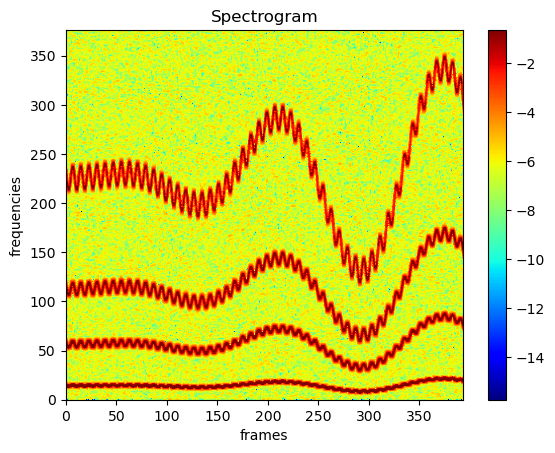

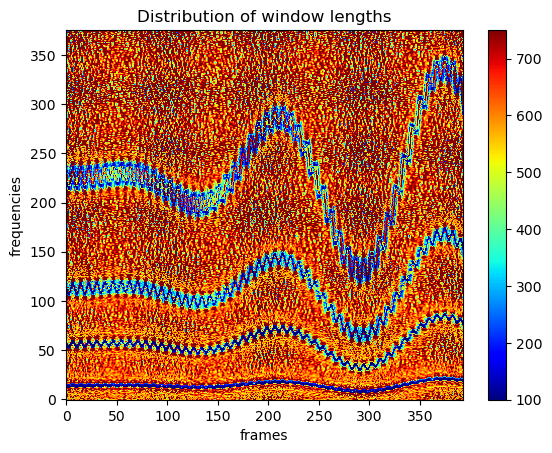

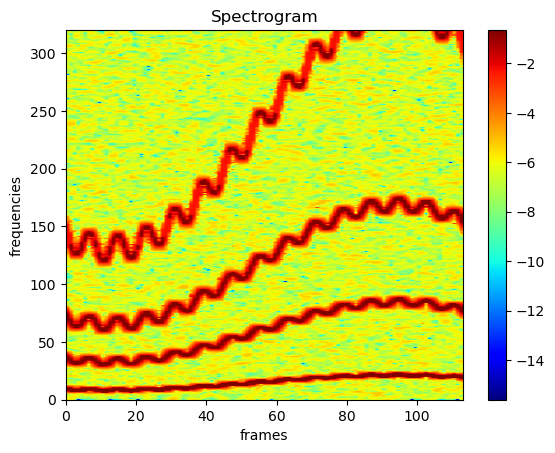

In [12]:
dstft = DSTFT(x, win_length=577,   support=support, stride=stride, win_requires_grad=True, stride_requires_grad=False, win_p='tf', win_min=100)
params = [{'params': dstft.win_length, 'lr': 100.0},  ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=99, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()
    spec, stft, *_ = dstft(x)
    err = entropy_loss(spec)
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
dstft.print(spec, x, bar=True, wins=False)
dstft.print(spec[:, :320, 280:410], x, bar=True, wins=False, weights=False)

with open("../fig/3_specs.pkl", "rb") as file: specs = pickle.load(file)
specs['tf'] = spec.detach().cpu()
with open("../fig/3_specs.pkl", "wb") as file: pickle.dump(specs, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/3_stfts.pkl", "rb") as file: stfts = pickle.load(file)
stfts['tf'] = stft.detach().cpu()
with open("../fig/3_stfts.pkl", "wb") as file: pickle.dump(stfts, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/3_wins.pkl", "rb") as file: wins = pickle.load(file)
wins['tf'] = dstft.actual_win_length.mean().detach().cpu()
with open("../fig/3_wins.pkl", "wb") as file: pickle.dump(wins, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/3_losses.pkl", "rb") as file: losses = pickle.load(file)
losses['tf'] = entropy_loss(spec).detach().cpu()
with open("../fig/3_losses.pkl", "wb") as file: pickle.dump(losses, file, pickle.HIGHEST_PROTOCOL)

torch.cuda.empty_cache()

Epoch 00165: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00290: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00394: reducing learning rate of group 0 to 1.0000e-01.
393


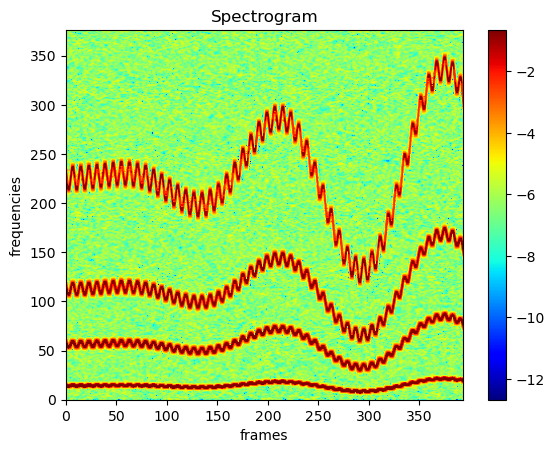

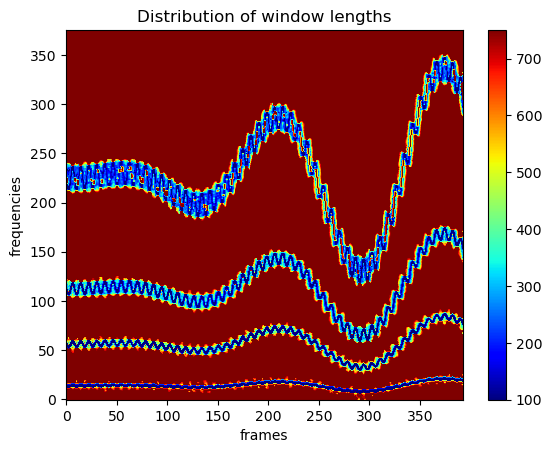

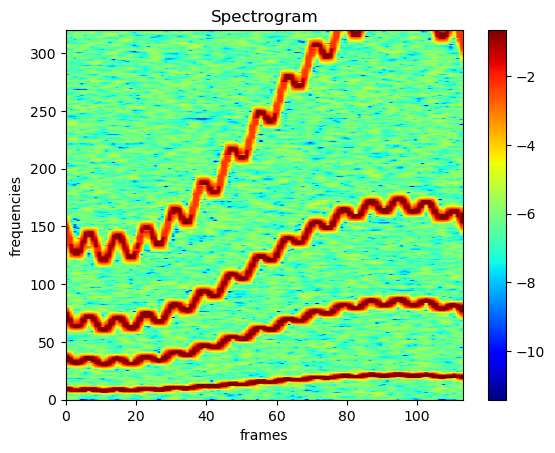

In [5]:
dstft = DSTFT(x, win_length=577,   support=support, stride=stride, win_requires_grad=True, stride_requires_grad=False, win_p='tf', win_min=100)
params = [{'params': dstft.win_length,'lr': 100.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=99, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()
    spec, stft, *_ = dstft(x)
    err = entropy_loss(spec) + 0.005 * (dstft.actual_win_length.diff(dim=0)[:, :-1].pow(2) + dstft.actual_win_length.diff(dim=1)[:-1].pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
dstft.print(spec, x, bar=True, wins=False)
dstft.print(spec[:, :320, 280:410], x, bar=True, wins=False, weights=False)

with open("../fig/3_specs.pkl", "rb") as file: specs = pickle.load(file)
specs['tf2'] = spec.detach().cpu()
with open("../fig/3_specs.pkl", "wb") as file: pickle.dump(specs, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/3_stfts.pkl", "rb") as file: stfts = pickle.load(file)
stfts['tf2'] = stft.detach().cpu()
with open("../fig/3_stfts.pkl", "wb") as file: pickle.dump(stfts, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/3_wins.pkl", "rb") as file: wins = pickle.load(file)
wins['tf2'] = dstft.actual_win_length.mean().detach().cpu()
with open("../fig/3_wins.pkl", "wb") as file: pickle.dump(wins, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/3_losses.pkl", "rb") as file: losses = pickle.load(file)
losses['tf2'] = entropy_loss(spec).detach().cpu()
with open("../fig/3_losses.pkl", "wb") as file: pickle.dump(losses, file, pickle.HIGHEST_PROTOCOL)

torch.cuda.empty_cache()

390


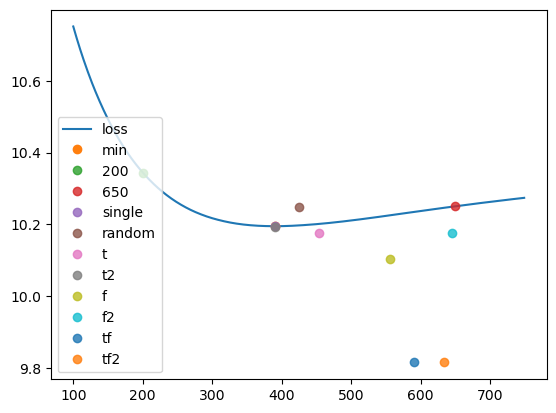

In [7]:
loss_function = []
min_err = 100
min_win = 0

for win_length in range(100, support, 1):
    dstft = FDSTFT(x, win_length=win_length, support=support, stride=stride, win_requires_grad=False, stride_requires_grad=False, win_p=None, stride_p=None)
    spec, stft, *_ = dstft(x)
    err = entropy_loss(spec)
    
    if err < min_err:
        min_err = err
        min_win = win_length
    loss_function.append(err.cpu())
    
print(min_win)
plt.plot(range(100, support, 1), loss_function, label='loss')
plt.plot(min_win, min_err.cpu(), 'o', label='min')

with open("../fig/3_losses.pkl", "rb") as file: losses = pickle.load(file)
with open("../fig/3_wins.pkl", "rb") as file: wins = pickle.load(file)
for key, loss in losses.items():
    plt.plot(wins[key], loss, 'o', alpha=.8, label=key)
plt.legend()
plt.show()

In [6]:
with open("../fig/3_stfts.pkl", "rb") as file: stfts = pickle.load(file)
with open("../fig/3_ss.pkl", "rb") as file: ss = pickle.load(file)
with open("../fig/3_losses2.pkl", "rb") as file: losses2 = pickle.load(file)

for key, stft in stfts.items():
    z = fast_sst(stft[0], 10, stft.shape[-2], stft.shape[-1], .2, device)
    ss[key] = z
    losses2[key] = entropy_loss(z).detach().cpu()
    
with open("../fig/3_ss.pkl", "wb") as file: pickle.dump(ss, file, pickle.HIGHEST_PROTOCOL)
with open("../fig/3_losses2.pkl", "wb") as file: pickle.dump(losses2, file, pickle.HIGHEST_PROTOCOL)

/home/maxime/Documents/Projects/MyProjects/dstft/dstft/synchrosqueeze.py:21: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995026/work/aten/src/ATen/native/Copy.cpp:276.)
  Z_Ts[eta, b] = Z_Ts[eta, b] + torch.mean(X[k, b])


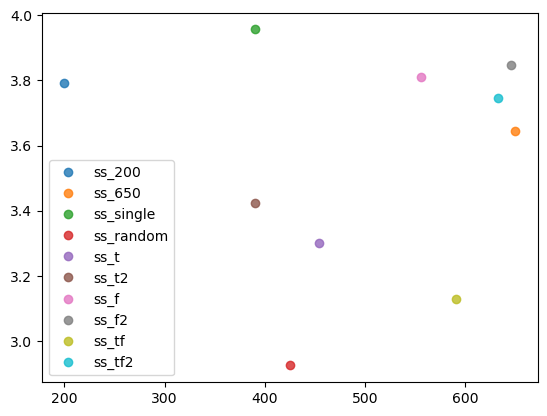

In [7]:
with open("../fig/3_losses2.pkl", "rb") as file: losses2 = pickle.load(file)
with open("../fig/3_wins.pkl", "rb") as file: wins = pickle.load(file)
for key, loss in losses2.items(): plt.plot(wins[key], loss, 'o', alpha=.8, label=f'ss_{key}')
plt.legend()
plt.show()

390


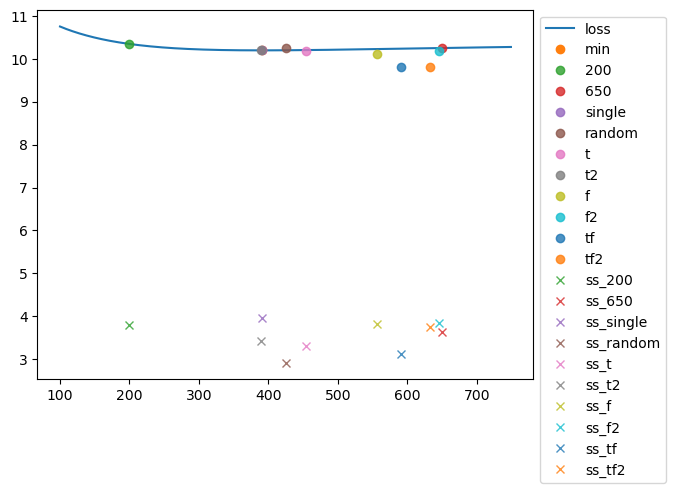

In [5]:
loss_function = []
min_err = 100
min_win = 0

for win_length in range(100, support, 1):
    dstft = FDSTFT(x, win_length=win_length, support=support, stride=100, win_requires_grad=False, stride_requires_grad=False, win_p=None, stride_p=None)
    spec, stft, *_ = dstft(x)
    err = entropy_loss(spec)
    
    if err < min_err:
        min_err = err
        min_win = win_length
    loss_function.append(err.cpu())
    
print(min_win)
plt.plot(range(100, support, 1), loss_function, label='loss')
plt.plot(min_win, min_err.cpu(), 'o', label='min')

with open("../fig/3_losses.pkl", "rb") as file: losses = pickle.load(file)
with open("../fig/3_losses2.pkl", "rb") as file: losses2 = pickle.load(file)
with open("../fig/3_wins.pkl", "rb") as file: wins = pickle.load(file)
for key, loss in losses.items(): plt.plot(wins[key], loss, 'o', alpha=.8, label=key)
for key, loss in losses2.items(): plt.plot(wins[key], loss, 'x', alpha=.8, label=f'ss_{key}')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

200


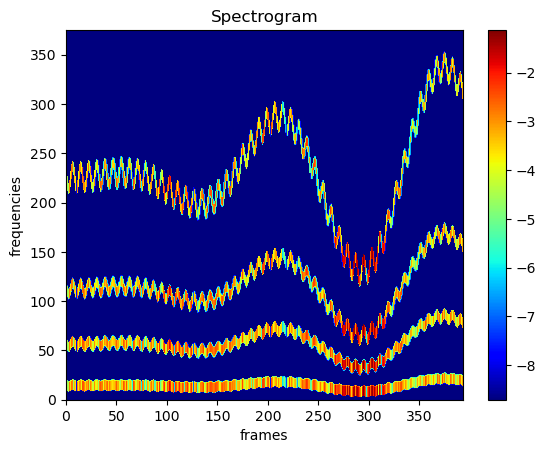

650


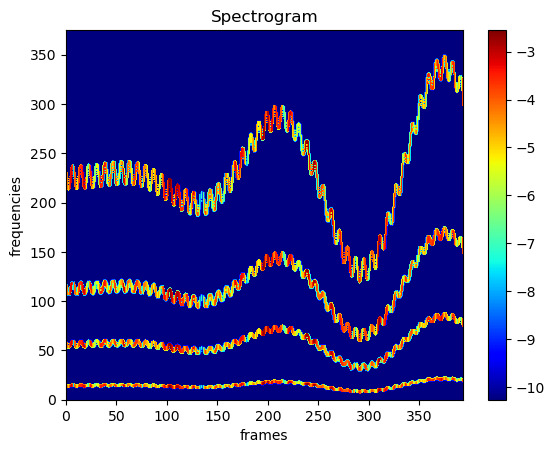

single


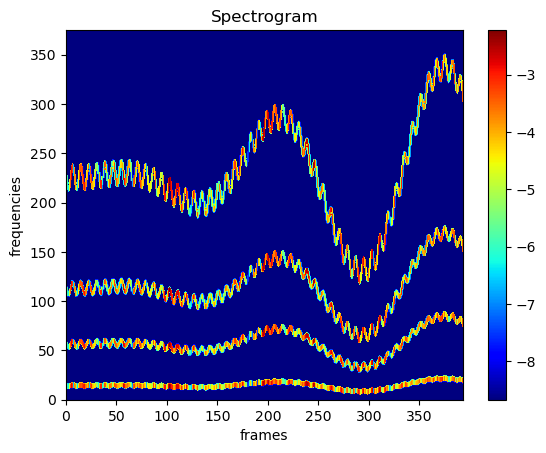

random


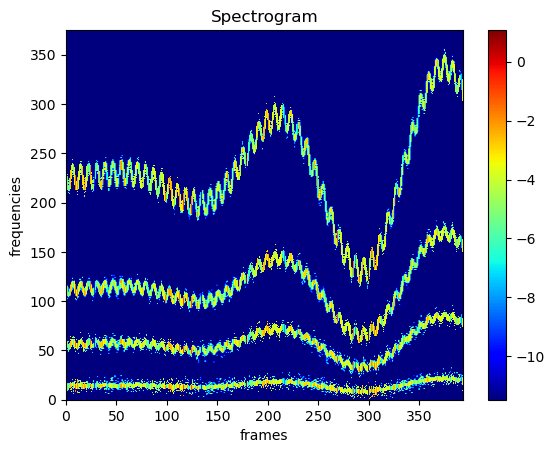

t


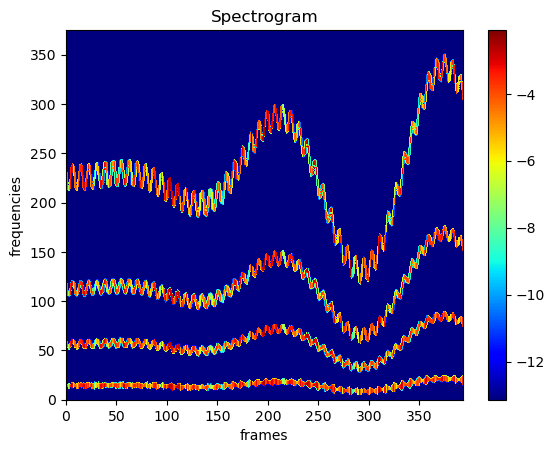

t2


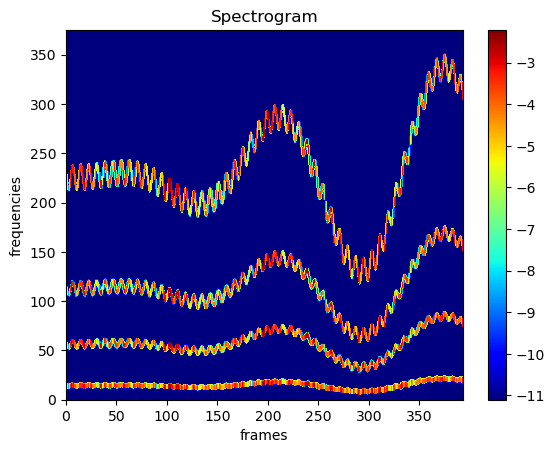

f


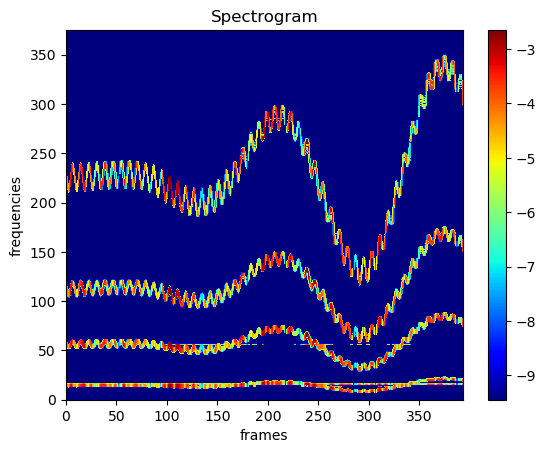

f2


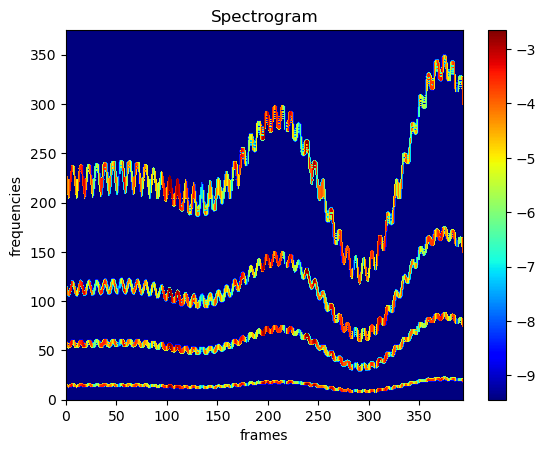

tf


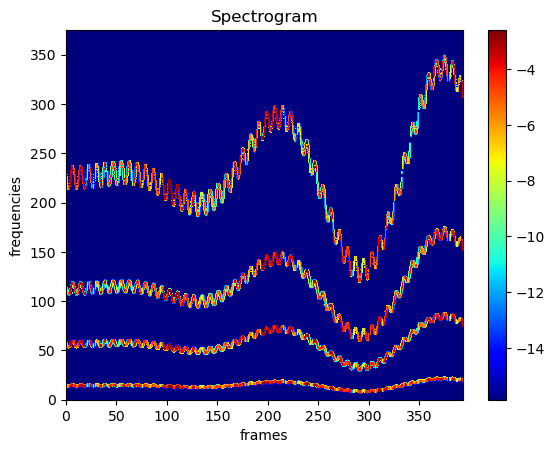

tf2


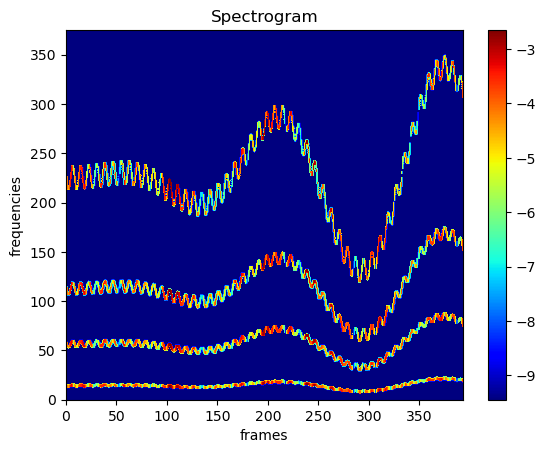

In [9]:
with open("../fig/3_ss.pkl", "rb") as file: ss = pickle.load(file)
for key, z in ss.items(): print(key); dstft.print(z[None, ...], x, bar=True, wins=False, weights=False)

200


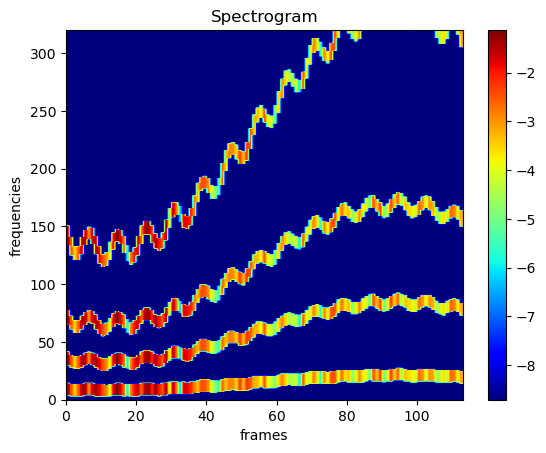

650


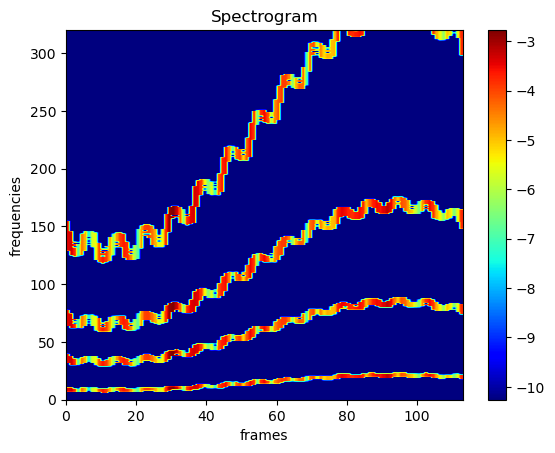

single


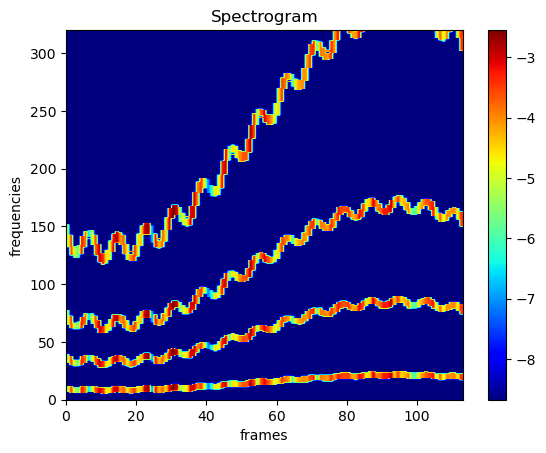

random


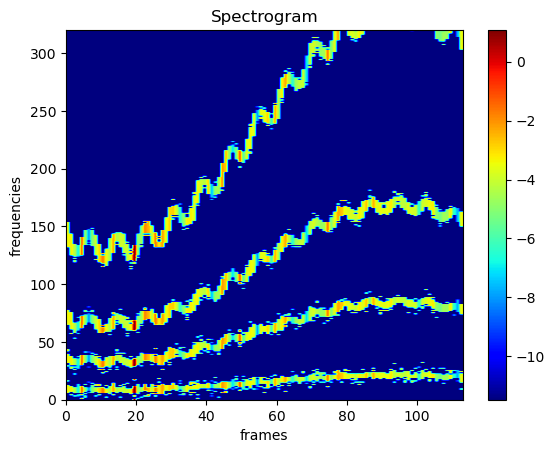

t


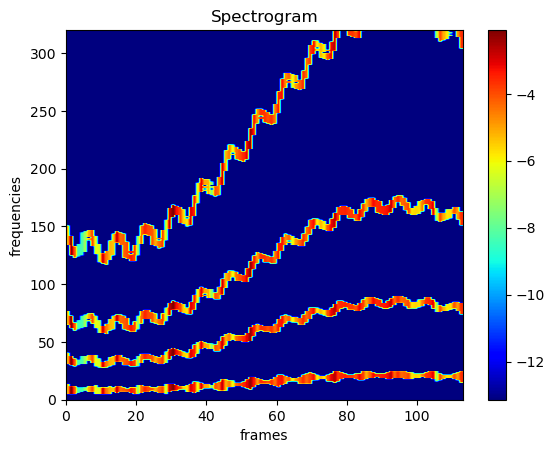

t2


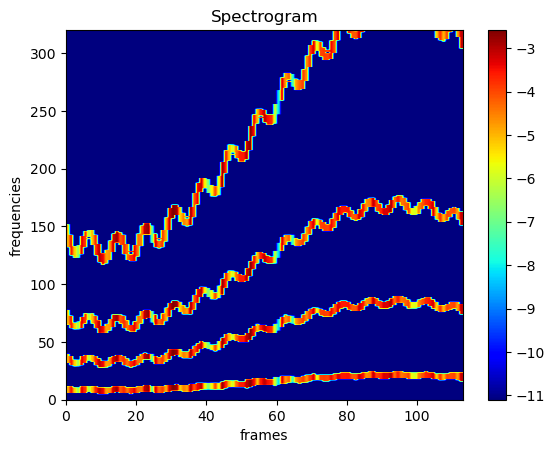

f


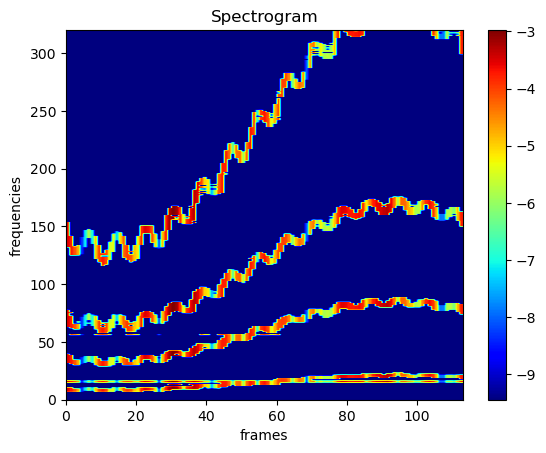

f2


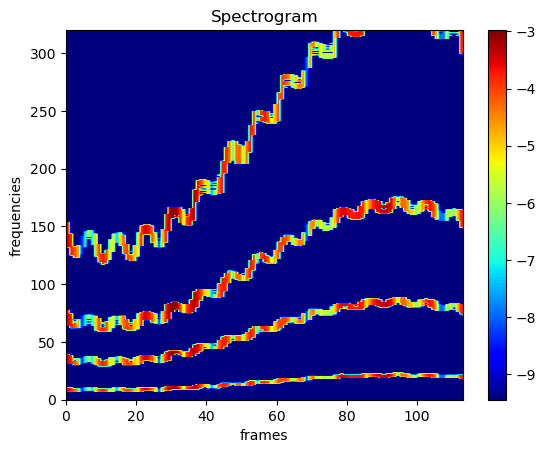

tf


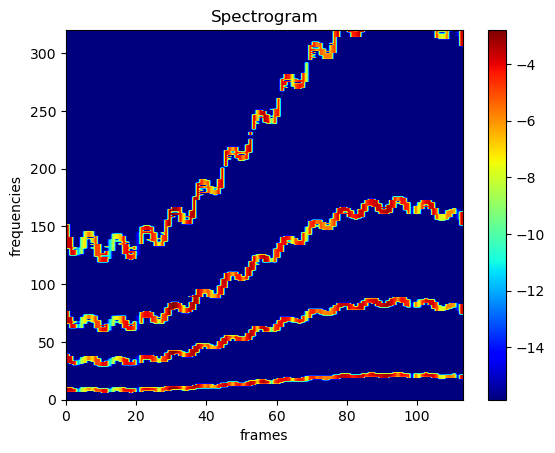

tf2


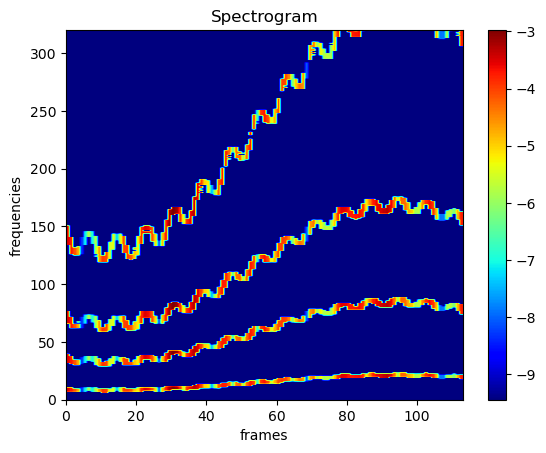

In [10]:
with open("../fig/3_ss.pkl", "rb") as file: ss = pickle.load(file)
for key, z in ss.items(): print(key); dstft.print(z[None, :320, 280:410], x, bar=True, wins=False, weights=False)

In [8]:
with open("../fig/3_specs.pkl", "rb") as file: specs = pickle.load(file)
with open("../fig/3_f_hats.pkl", "rb") as file: f_hats = pickle.load(file)
for key, spec in specs.items():
    f_hat, out = frequency_tracking(y=x, fs=1e4, spec=spec[0], fmin=0, fmax=.1, alpha=100, orders=[4, 8, 16])
    f_hats[key] = out
    # f_hat = torch.nn.functional.interpolate((out*fs/2/spec.shape[0])[None, None, None, ...], size=x[0].shape[-1], mode='bicubic').squeeze()[0]

with open("../fig/3_f_hats.pkl", "wb") as file: pickle.dump(f_hats, file, pickle.HIGHEST_PROTOCOL)

IndexError: The shape of the mask [377] at index 0 does not match the shape of the indexed tensor [376] at index 0

In [ ]:
with open("../fig/3_specs.pkl", "rb") as file: specs = pickle.load(file)
with open("../fig/3_ss.pkl", "rb") as file: ss = pickle.load(file)
with open("../fig/3_f_hats.pkl", "rb") as file: f_hats = pickle.load(file)

for key, out in f_hats.items(): 
    print(key)
    
    plt.figure()
    plt.title(f'Spectrogram {key}')
    ax = plt.subplot()
    im = ax.imshow(specs[key][0].log(), aspect='auto', origin='lower', cmap='jet', extent=[0,spec.shape[-1], 0, spec.shape[-2]])
    plt.ylabel('frequencies')
    plt.xlabel('frames')
    plt.colorbar(im, ax=ax)
    plt.plot(out, 'k', alpha=.5,  linewidth=1)
    plt.show()
    
    plt.figure()
    plt.title(f'Synchrosqueeze {key}')
    ax = plt.subplot()
    im = ax.imshow(ss[key].log(), aspect='auto', origin='lower', cmap='jet', extent=[0,spec.shape[-1], 0, spec.shape[-2]])
    plt.ylabel('frequencies')
    plt.xlabel('frames')
    plt.colorbar(im, ax=ax)
    plt.plot(out, 'k', alpha=.5,  linewidth=1)
    plt.show()